## About Dataset  
Introduction  
The lack of publicly available National Football League (NFL) data sources has been a major obstacle in the creation of modern, reproducible research in football analytics. While clean play-by-play data is available via open-source software packages in other sports (e.g. nhlscrapr for hockey; PitchF/x data in baseball; the Basketball Reference for basketball), the equivalent datasets are not freely available for researchers interested in the statistical analysis of the NFL. To solve this issue, a group of Carnegie Mellon University statistical researchers including Maksim Horowitz, Ron Yurko, and Sam Ventura, built and released nflscrapR an R package which uses an API maintained by the NFL to scrape, clean, parse, and output clean datasets at the individual play, player, game, and season levels. Using the data outputted by the package, the trio went on to develop reproducible methods for building expected point and win probability models for the NFL. The outputs of these models are included in this dataset and can be accessed using the nflscrapR package.  
  
Content  
The dataset made available on Kaggle contains all the regular season plays from the 2009-2016 NFL seasons. The dataset has 356,768 rows and 100 columns. Each play is broken down into great detail containing information on: game situation, players involved, results, and advanced metrics such as expected point and win probability values. Detailed information about the dataset can be found at the following web page, along with more NFL data: https://github.com/ryurko/nflscrapR-data.

<font size='2' face='Arial'>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nflplaybyplay2009to2016/NFL Play by Play 2009-2017 (v4).csv
/kaggle/input/nflplaybyplay2009to2016/NFL Play by Play 2009-2016 (v3).csv
/kaggle/input/nflplaybyplay2009to2016/NFL Play by Play 2009-2018 (v5).csv


<div style="text-align: center;">
  <span style="font-size: 20em;">🏈</span>
</div>

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv('/kaggle/input/nflplaybyplay2009to2016/NFL Play by Play 2009-2018 (v5).csv', low_memory=False)
df

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449366,4059,2018121700,CAR,NO,CAR,home,NO,CAR,66.0,2018-12-17,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
449367,4081,2018121700,CAR,NO,CAR,home,NO,CAR,66.0,2018-12-17,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
449368,4106,2018121700,CAR,NO,CAR,home,NO,CAR,61.0,2018-12-17,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
449369,4128,2018121700,CAR,NO,NO,away,CAR,CAR,39.0,2018-12-17,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


## Challenges

<font size='5' color=red face='Arial'>


1. Calculate the win-loss point system,based on the team scores;
2. Using given data, analyse which team is the best;
3. Teams better playing at home field or away?
    
<font size='2' face='Arial'>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449371 entries, 0 to 449370
Columns: 255 entries, play_id to defensive_extra_point_conv
dtypes: float64(135), int64(18), object(102)
memory usage: 874.2+ MB


In [5]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Column': df.columns, 'Missing Percentage': missing_percentage})
missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False)

with pd.option_context('display.max_rows', None):
    print(missing_df)


                                                                    Column  \
assist_tackle_4_team                                  assist_tackle_4_team   
assist_tackle_4_player_id                        assist_tackle_4_player_id   
lateral_sack_player_id                              lateral_sack_player_id   
lateral_sack_player_name                          lateral_sack_player_name   
assist_tackle_4_player_name                    assist_tackle_4_player_name   
assist_tackle_3_player_id                        assist_tackle_3_player_id   
assist_tackle_3_player_name                    assist_tackle_3_player_name   
assist_tackle_3_team                                  assist_tackle_3_team   
tackle_for_loss_2_player_name                tackle_for_loss_2_player_name   
tackle_for_loss_2_player_id                    tackle_for_loss_2_player_id   
lateral_rusher_player_id                          lateral_rusher_player_id   
lateral_rusher_player_name                      lateral_rusher_p

## Is Data ROCCC?

<font size='5'  face='Arial'>

**Reliability**  🟢  
Data is consistent across different variables and time periods;  
Accuracy is high. I checked some wsites, like: https://www.espn.com/ and data is the same;  
Bias. Here we have all kinds of variables and measures, which gives us a lot of space for subtle calculations.  
  
**Originality**  🟢  
Original dataset with distinct features or variables offer valuable information for analysis;  
Dataset includes novel perspectives or information that is not readily available in other sources.  
  
**Comprehensiveness**  🟢  
Covers a wide range of aspects related to the subject matter, such as different game statistics, player attributes, team performances, and other relevant variables.  
  
**Currency**  🟡  
Data taken from period between 2009 and 2018 and hasn't been updates since. With more then 5 years gap such inforrmation in many ways can be out of date. Players can change, teams can have different coaches, performance etc.  
  
**Citations**  🔴  
In data description we saw:*built and released nflscrapR an R package which uses an API maintained by the NFL to scrape, clean, parse, and output clean datasets at the individual play, player, game, and season levels*. It's not reveals where this API taken from. No links to open sourses, no trasparensy about how data trasnformed and extracted, only link to GitHub page with R-code.  
Creators of this data left link to their page: Carnegie Mellon Sports Analytics Club, which is no longer exists.     

<font size='2' face='Arial'>



## Data Cleaning

In [6]:
overall_missing_percentage = (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100
print(f"Overall Missing Percentage: {overall_missing_percentage:.2f}%")


Overall Missing Percentage: 38.50%


<font size='4' face='Arial'>

Why there are a few cleaning steps in code below? Well, because there are a lot of columns and first I investigated them step by step. 
Asking myself:"Why is data missing? Is it valuable information or not? Is it empty because there are missing values or only specific values pointed in a column?". 
After analysing cohorts of columns by % of missing values I assumed, that removing them won't affect my farther calculations.
    
<font size='2' face='Arial'>

In [7]:
columns_to_drop = missing_df[missing_df['Missing Percentage'] == 100]['Column']
df = df.drop(columns=columns_to_drop)

columns_to_drop_90_99 = missing_df[(missing_df['Missing Percentage'] >= 90) & (missing_df['Missing Percentage'] < 100)]['Column']
df = df.drop(columns=columns_to_drop_90_99)

columns_to_drop_90_99 = missing_df[(missing_df['Missing Percentage'] >=14 ) & (missing_df['Missing Percentage'] < 90)]['Column']
df = df.drop(columns=columns_to_drop_90_99)

In [8]:
overall_missing_percentage = (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100
print(f"Overall Missing Percentage: {overall_missing_percentage:.2f}%")

Overall Missing Percentage: 1.64%


In [9]:
# Of course, checking for duplicates.

duplicates = df[df.duplicated()]
num_duplicates = duplicates.shape[0]
print(f"Number of Duplicate Rows: {num_duplicates}")

Number of Duplicate Rows: 2389


In [10]:
df = df.drop_duplicates()

In [11]:
# Now our data is clean and ready

duplicates = df[df.duplicated()]
num_duplicates = duplicates.shape[0]
print(f"Number of Duplicate Rows: {num_duplicates}")

Number of Duplicate Rows: 0


In [12]:
# 100 columns were removed from DataFrame

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 446982 entries, 0 to 449370
Columns: 149 entries, play_id to defensive_extra_point_conv
dtypes: float64(119), int64(18), object(12)
memory usage: 511.5+ MB


In [13]:
# When I was cheking info about teams in websites, I've noticed, that some of them has 2 different names. Let's fix it.

equivalent_teams = {
    'SD': 'LAC',  # San Diego Chargers and Los Angeles Chargers
    'OAK': 'LV',  # Oakland Raiders and Las Vegas Raiders
    'STL': 'LA',  # St. Louis Rams and Los Angeles Rams
    'WAS': 'WAS',  # Washington Football Team (Formerly Washington Redskins)
    'JAX': 'JAC',  # Jacksonville Jaguars and JAX
}

for abbrev, full in equivalent_teams.items():
    df['home_team'].replace(abbrev, full, inplace=True)
    df['away_team'].replace(abbrev, full, inplace=True)


<font size='4' face='Arial'>

I was analysing data for a couple of days in my free time. I am far from NFL and their rules, but writing code for counting wins I always calculated some astronomical numbers of win points, which only be possible if each team had at least 1000 games per year, which is, obviously, can't be real. No matter what code I wrote, the numbers were not right. And then it hit me, lads! 
In this data they have game id, which is meassuring score over and over again for the same game, that's why there are so many rows. 
Look at the code below and you see, that 1 game can has 100-300 rows, which was the reason why calculation were wrong. 
Well, that's why there are Data Analysts, innit? So we can investigate and understand the data.
    
<font size='2' face='Arial'>

In [14]:
game_id_value_counts = df['game_id'].value_counts()
print(game_id_value_counts)

game_id
2011120406    272
2018093004    238
2018093009    237
2016112709    232
2016103000    231
             ... 
2015092705    146
2012110100    146
2013090801    145
2009122706    145
2013120806    125
Name: count, Length: 2526, dtype: int64


In [15]:
filtered_rows = df[df['game_id'] == 2014101202]
print(filtered_rows[['home_team', 'away_team', 'total_home_score', 'total_away_score', 'posteam_score_post', 'defteam_score_post']])


       home_team away_team  total_home_score  total_away_score  \
239010       CIN       CAR                 0                 0   
239011       CIN       CAR                 0                 0   
239012       CIN       CAR                 0                 0   
239013       CIN       CAR                 0                 0   
239014       CIN       CAR                 0                 0   
...          ...       ...               ...               ...   
239230       CIN       CAR                37                37   
239231       CIN       CAR                37                37   
239232       CIN       CAR                37                37   
239233       CIN       CAR                37                37   
239234       CIN       CAR                37                37   

        posteam_score_post  defteam_score_post  
239010                 0.0                 0.0  
239011                 0.0                 0.0  
239012                 0.0                 0.0  
239013     

In [16]:
# Getting rid of extra rows, so we can have rows only with final score in each game

columns_to_keep = ['game_id', 'game_date', 'home_team', 'away_team', 'total_home_score', 'total_away_score','posteam_score_post',
                   'defteam_score_post']
final_scores = df.groupby('game_id')[columns_to_keep].tail(1)

print(final_scores)

           game_id   game_date home_team away_team  total_home_score  \
177     2009091000  2009-09-10       PIT       TEN                13   
349     2009091304  2009-09-13       CLE       MIN                19   
531     2009091307  2009-09-13        NO       DET                45   
702     2009091308  2009-09-13        TB       DAL                21   
865     2009091305  2009-09-13       HOU       NYJ                 6   
...            ...         ...       ...       ...               ...   
448663  2018121605  2018-12-16       IND       DAL                23   
448850  2018121609  2018-12-16        SF       SEA                26   
449013  2018121610  2018-12-16       PIT        NE                17   
449201  2018121611  2018-12-16        LA       PHI                23   
449370  2018121700  2018-12-17       CAR        NO                 7   

        total_away_score  posteam_score_post  defteam_score_post  
177                   10                13.0                10.0  
3

In [17]:
# 2526 games for 10 years seems more real

final_scores.head(15)

,game_id,game_date,home_team,away_team,total_home_score,total_away_score,posteam_score_post,defteam_score_post
177,2009091000,2009-09-10,PIT,TEN,13,10,13.0,10.0
349,2009091304,2009-09-13,CLE,MIN,19,34,NaN,NaN
531,2009091307,2009-09-13,NO,DET,45,26,NaN,NaN
702,2009091308,2009-09-13,TB,DAL,21,34,NaN,NaN
865,2009091305,2009-09-13,HOU,NYJ,6,24,NaN,NaN
1026,2009091306,2009-09-13,IND,JAC,14,12,NaN,NaN
1183,2009091303,2009-09-13,CIN,DEN,7,12,7.0,12.0
1369,2009091302,2009-09-13,CAR,PHI,10,36,NaN,NaN
1551,2009091301,2009-09-13,BAL,KC,38,23,NaN,NaN
1712,2009091300,2009-09-13,ATL,MIA,19,7,NaN,NaN


## Challenge 1. Win points

<font size='4' face='Arial'>

A little explanation about below info and code. 
At first, I made a function based on total_away_score and total_home_score. Among Wins and Losses, it returned about 160 Ties (Which is about 15% of all games). In basic info about NFL it says, that ties are extremely rare.  
For farther investigation I add columns posteam_score_post and defteam_score_post, which represent score in additional time (The values there are mostly NaN, because not every game has overtime).    
Finally, 14 rows left with Tie count. Enough, to check it ourselves (Well, yes. We have penalty cohort of columns, but it is not make define winner easier, because of the each step counts and mixed type format info in them).  
So, to avoid confusion with too much code, I will write links to all the post scores ties from the info taken from the internet to add them to farther write a correct function.
    
<font size='1' face='Arial'>

14 games with tie score. I guess, we can check them ourselves. Here's what I found:

1. 2010092700, 2010-09-27    
CHI > GB  (20 - 17)  
https://www.espn.com/nfl/recap/_/gameId/300927003  
2. 2011010207, 2011-01-02     
PHI < DAL  (13 - 14)    
https://www.espn.com/nfl/game/_/gameId/310102021    
3. 2012111110, 2012-11-11    
SF = STL (24 - 24)    
https://www.espn.com/nfl/game/_/gameId/321111025/rams-49ers  
4. 2013112403, 2013-11-24    
GB = MIN (26 - 26)  
https://www.espn.com/nfl/game/_/gameId/331124009/vikings-packers  
5. 2013122900, 2013-12-29  
ATL < CAR (20 - 21)  
https://www.espn.com/nfl/game/_/gameId/331229001  
6. 2014101202, 2014-10-12    
CIN = CAR (37 - 37)  
https://www.espn.com/nfl/game/_/gameId/400554263  
7. 2014113004,2014-11-30    
JAC > NYG (25 - 24)  
https://www.espn.com/nfl/game/_/gameId/400554327  
8. 2015120602, 2015-12-06  
MIA > BAL  (15 - 13)  
https://www.espn.com/nfl/game/_/gameId/400791615  
9. 2016102312, 2016-10-23  
ARI = SEA (6 - 6)   
https://www.espn.com/nfl/game/_/gameId/400874508  
10. 2016103000, 2016-10-30  
CIN = WAS  (27 - 27)  
https://www.espn.com/nfl/game/_/gameId/400874555  
11. 2016111303, 2016-11-13  
NO < DEN  (23 - 25)  
https://www.espn.com/nfl/game/_/gameId/400874586  
12. 2017010109, 2017-01-01  
TB > CAR (17 - 16)  
https://www.espn.com/nfl/game/_/gameId/400874635  
13. 2017102902, 2017-10-29  
CIN > IND (24 - 23)  
https://www.espn.com/nfl/game/_/gameId/400951711  
14. 2018090901, 2018-09-09  
CLE = PIT (21 - 21)   
https://www.espn.com/nfl/game/_/gameId/401030718  
  

  
Also Ties info:  
https://en.wikipedia.org/wiki/List_of_NFL_tied_games

In [18]:
# Update the values of total_home_score and total_away_score for all 14 games

# Game 2010092700, 2010-09-27 (CHI > GB)
final_scores.loc[final_scores['game_id'] == 2010092700, 'total_home_score'] = 20
final_scores.loc[final_scores['game_id'] == 2010092700, 'total_away_score'] = 17

# Game 2011010207, 2011-01-02 (PHI < DAL)
final_scores.loc[final_scores['game_id'] == 2011010207, 'total_home_score'] = 13
final_scores.loc[final_scores['game_id'] == 2011010207, 'total_away_score'] = 14

# Game 2012111110, 2012-11-11 (SF = STL)
final_scores.loc[final_scores['game_id'] == 2012111110, 'total_home_score'] = 24
final_scores.loc[final_scores['game_id'] == 2012111110, 'total_away_score'] = 24

# Game 2013112403, 2013-11-24 (GB = MIN)
final_scores.loc[final_scores['game_id'] == 2013112403, 'total_home_score'] = 26
final_scores.loc[final_scores['game_id'] == 2013112403, 'total_away_score'] = 26

# Game 2013122900, 2013-12-29 (ATL < CAR)
final_scores.loc[final_scores['game_id'] == 2013122900, 'total_home_score'] = 20
final_scores.loc[final_scores['game_id'] == 2013122900, 'total_away_score'] = 21

# Game 2014101202, 2014-10-12 (CIN = CAR)
final_scores.loc[final_scores['game_id'] == 2014101202, 'total_home_score'] = 37
final_scores.loc[final_scores['game_id'] == 2014101202, 'total_away_score'] = 37

# Game 2014113004, 2014-11-30 (JAC > NYG)
final_scores.loc[final_scores['game_id'] == 2014113004, 'total_home_score'] = 25
final_scores.loc[final_scores['game_id'] == 2014113004, 'total_away_score'] = 24

# Game 2015120602, 2015-12-06 (MIA > BAL)
final_scores.loc[final_scores['game_id'] == 2015120602, 'total_home_score'] = 15
final_scores.loc[final_scores['game_id'] == 2015120602, 'total_away_score'] = 13

# Game 2016102312, 2016-10-23 (ARI = SEA)
final_scores.loc[final_scores['game_id'] == 2016102312, 'total_home_score'] = 6
final_scores.loc[final_scores['game_id'] == 2016102312, 'total_away_score'] = 6

# Game 2016103000, 2016-10-30 (CIN = WAS)
final_scores.loc[final_scores['game_id'] == 2016103000, 'total_home_score'] = 27
final_scores.loc[final_scores['game_id'] == 2016103000, 'total_away_score'] = 27

# Game 2016111303, 2016-11-13 (NO < DEN)
final_scores.loc[final_scores['game_id'] == 2016111303, 'total_home_score'] = 23
final_scores.loc[final_scores['game_id'] == 2016111303, 'total_away_score'] = 25

# Game 2017010109, 2017-01-01 (TB > CAR)
final_scores.loc[final_scores['game_id'] == 2017010109, 'total_home_score'] = 17
final_scores.loc[final_scores['game_id'] == 2017010109, 'total_away_score'] = 16

# Game 2017102902, 2017-10-29 (CIN > IND)
final_scores.loc[final_scores['game_id'] == 2017102902, 'total_home_score'] = 24
final_scores.loc[final_scores['game_id'] == 2017102902, 'total_away_score'] = 23

# Game 2018090901, 2018-09-09 (CLE = PIT)
final_scores.loc[final_scores['game_id'] == 2018090901, 'total_home_score'] = 21
final_scores.loc[final_scores['game_id'] == 2018090901, 'total_away_score'] = 21


<font size='2' face='Arial'>
    
Now we are ready to write a function

In [19]:
# Creating function to calculate points by scores in the game

def calculate_points(row):
    if row['total_home_score'] > row['total_away_score']:
        return 2, 0
    elif row['total_home_score'] < row['total_away_score']:
        return 0, 2
    else:
        if row['posteam_score_post'] > row['defteam_score_post']:
            return 2, 0
        elif row['posteam_score_post'] < row['defteam_score_post']:
            return 0, 2
        else:
            return 1, 1

final_scores['home_team_points'], final_scores['away_team_points'] = zip(*final_scores.apply(calculate_points, axis=1))

In [20]:
filtered_games = final_scores[(final_scores['home_team_points'] == 1) | (final_scores['away_team_points'] == 1)]
filtered_games.head(15)

,game_id,game_date,home_team,away_team,total_home_score,total_away_score,posteam_score_post,defteam_score_post,home_team_points,away_team_points
159877,2012111110,2012-11-11,SF,LA,24,24,NaN,NaN,1,1
209064,2013112403,2013-11-24,GB,MIN,26,26,NaN,NaN,1,1
239234,2014101202,2014-10-12,CIN,CAR,37,37,37.0,37.0,1,1
335576,2016102312,2016-10-23,ARI,SEA,6,6,NaN,NaN,1,1
336171,2016103000,2016-10-30,CIN,WAS,27,27,27.0,27.0,1,1
409051,2018090901,2018-09-09,CLE,PIT,21,21,NaN,NaN,1,1


<div style="text-align: center;">
  <span style="font-size: 10em;">✅</span>
</div>

## Challenge 2. Which team is the best? 

In [21]:
team_points = {}
for index, row in final_scores.iterrows():
    home_team = row['home_team']
    if home_team in team_points:
        team_points[home_team] += row['home_team_points']
    else:
        team_points[home_team] = row['home_team_points']

    away_team = row['away_team']
    if away_team in team_points:
        team_points[away_team] += row['away_team_points']
    else:
        team_points[away_team] = row['away_team_points']

total_points_df = pd.DataFrame(list(team_points.items()), columns=['Team', 'Total_Points'])
total_points_df = total_points_df.sort_values(by='Total_Points', ascending=False)


print(total_points_df)

   Team  Total_Points
28   NE           242
0   PIT           207
26   GB           199
4    NO           198
22  SEA           185
16  BAL           182
13  DEN           180
18  ATL           180
7   DAL           176
10  IND           174
15  PHI           174
12  CIN           172
17   KC           172
31  LAC           168
3   MIN           167
14  CAR           161
8   HOU           160
20  ARI           159
21   SF           151
27  CHI           146
24  NYG           144
19  MIA           142
5   DET           140
9   NYJ           140
1   TEN           134
29  BUF           132
23   LA           127
25  WAS           127
30   LV           120
6    TB           110
11  JAC           102
2   CLE            81


/tmp/ipykernel_19/1776933647.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


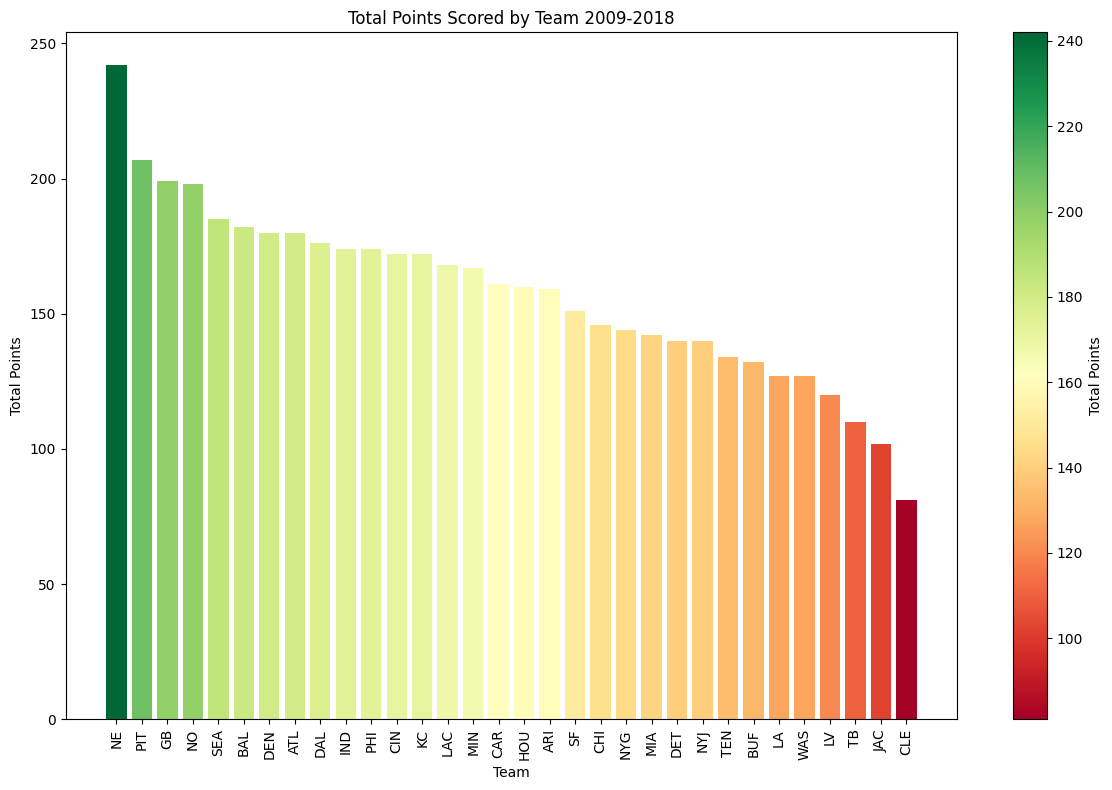

In [22]:
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


total_points_df = total_points_df.sort_values(by='Total_Points', ascending=False)

cmap = plt.cm.RdYlGn
norm = plt.Normalize(total_points_df['Total_Points'].min(), total_points_df['Total_Points'].max())

plt.figure(figsize=(12, 8))
bars = plt.bar(total_points_df['Team'], total_points_df['Total_Points'], color=cmap(norm(total_points_df['Total_Points'])))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm)
cbar.set_label('Total Points')

plt.xlabel('Team')
plt.ylabel('Total Points')
plt.title('Total Points Scored by Team 2009-2018')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

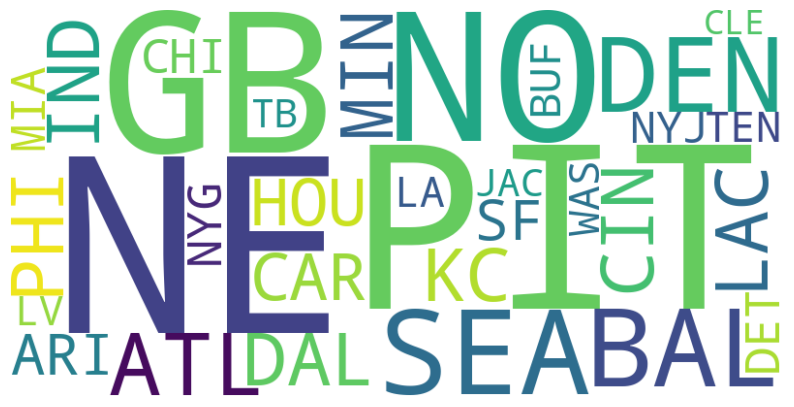

In [23]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(total_points_df.set_index('Team')['Total_Points'])

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


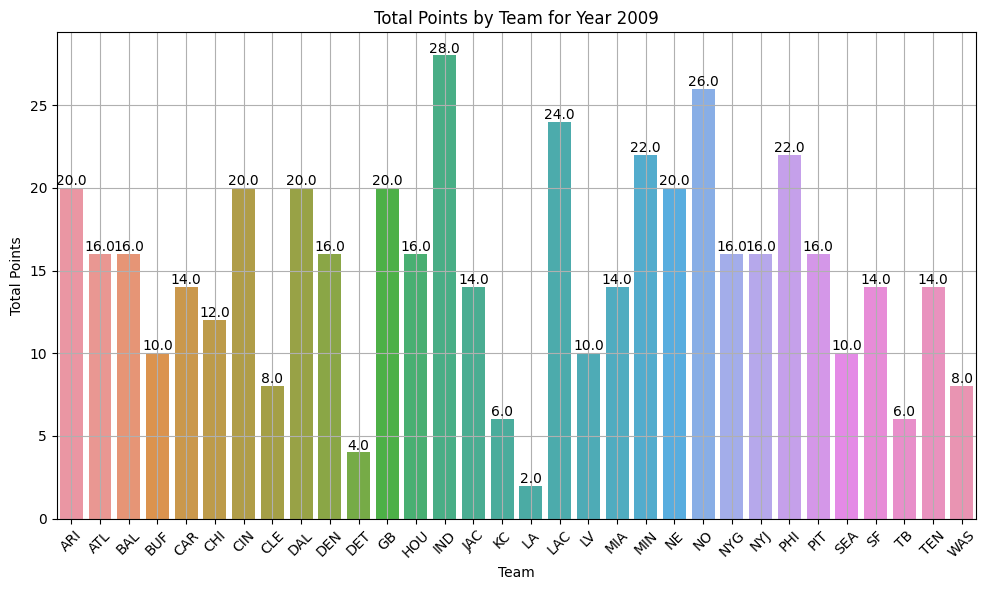

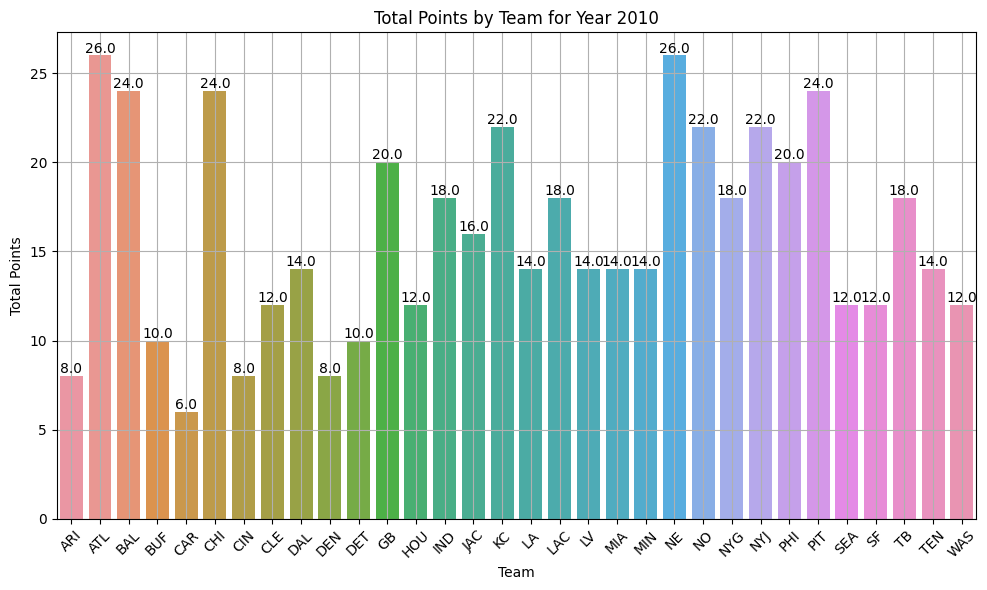

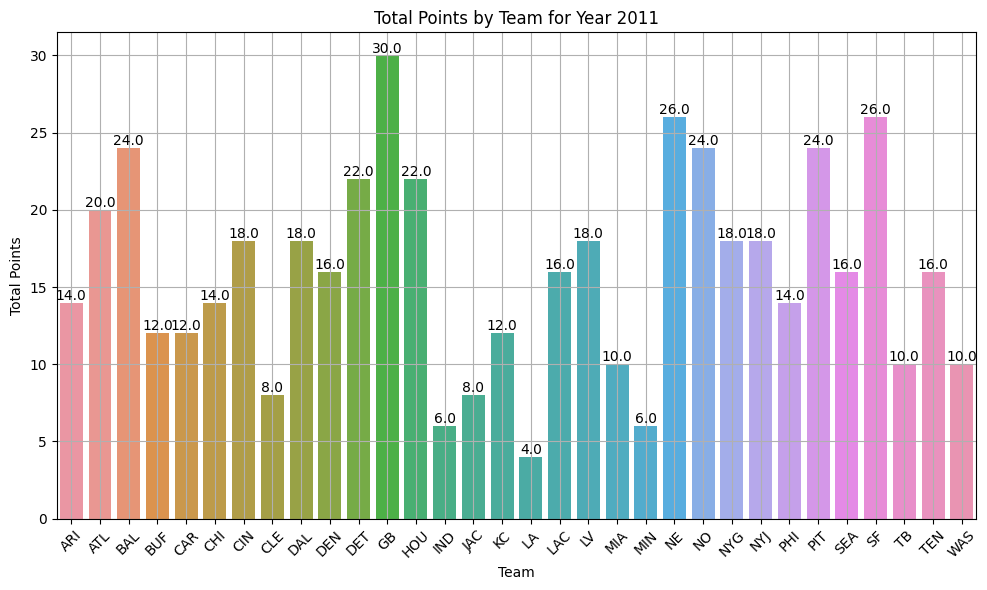

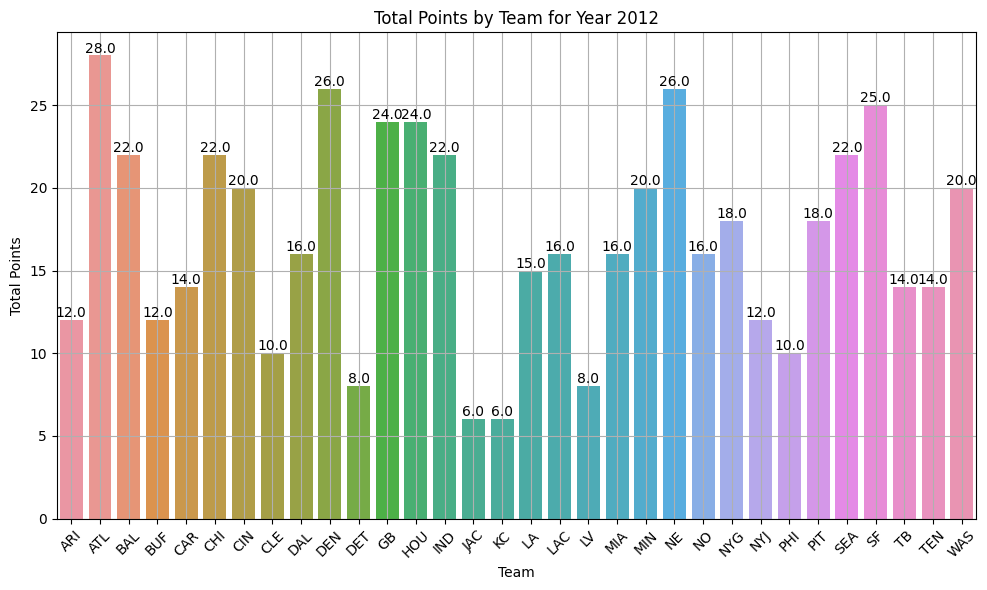

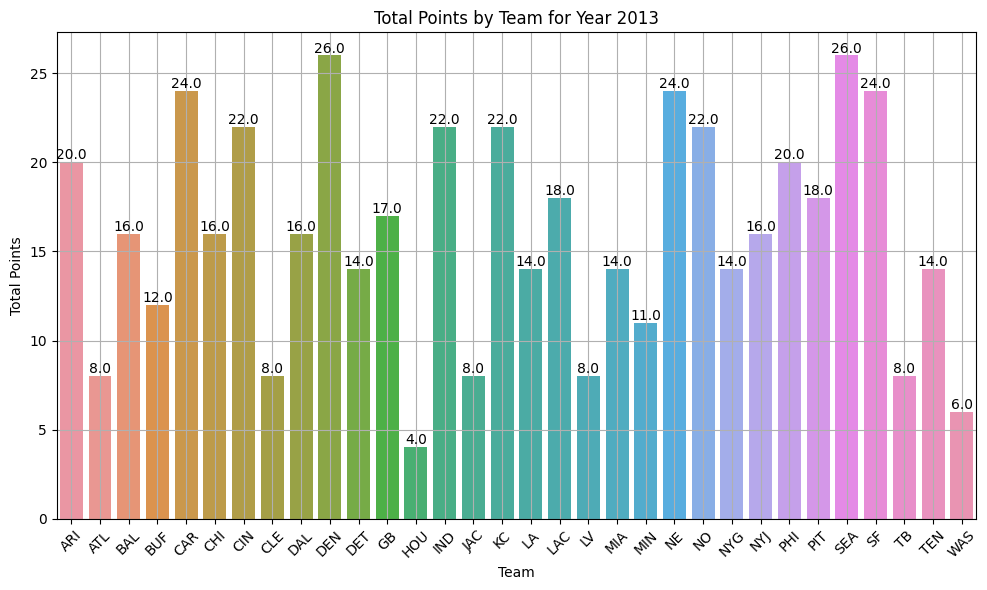

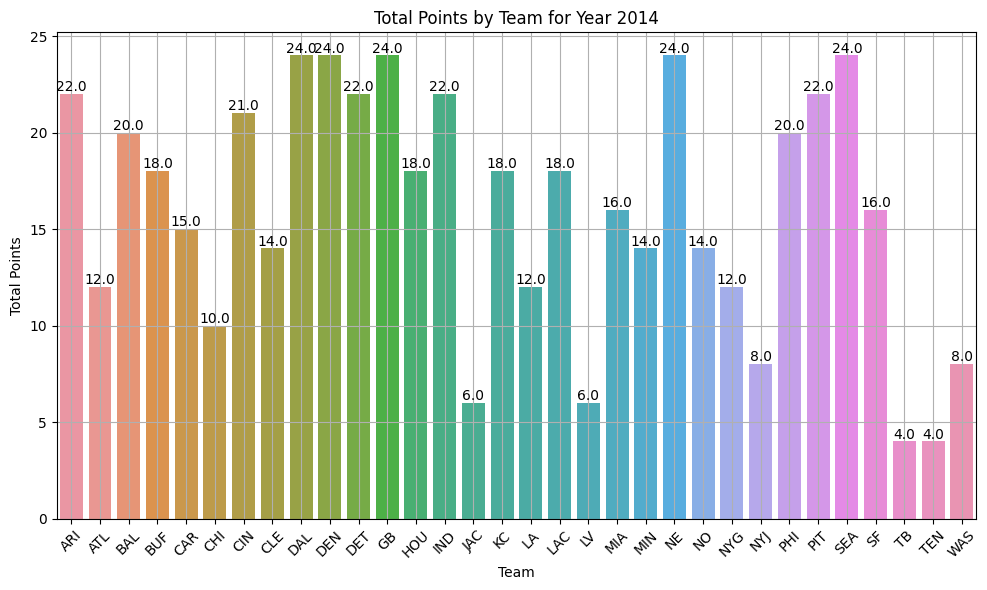

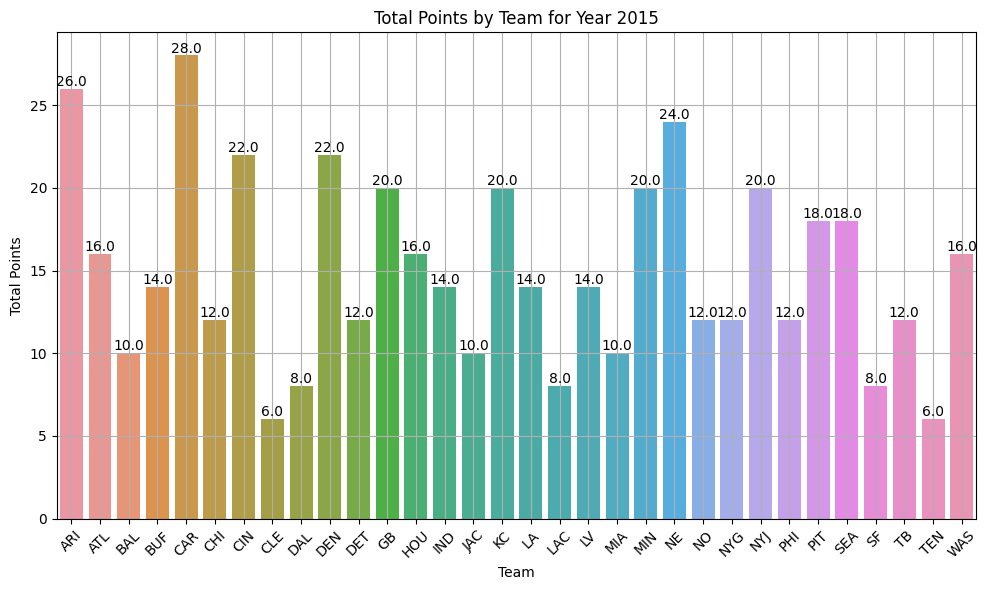

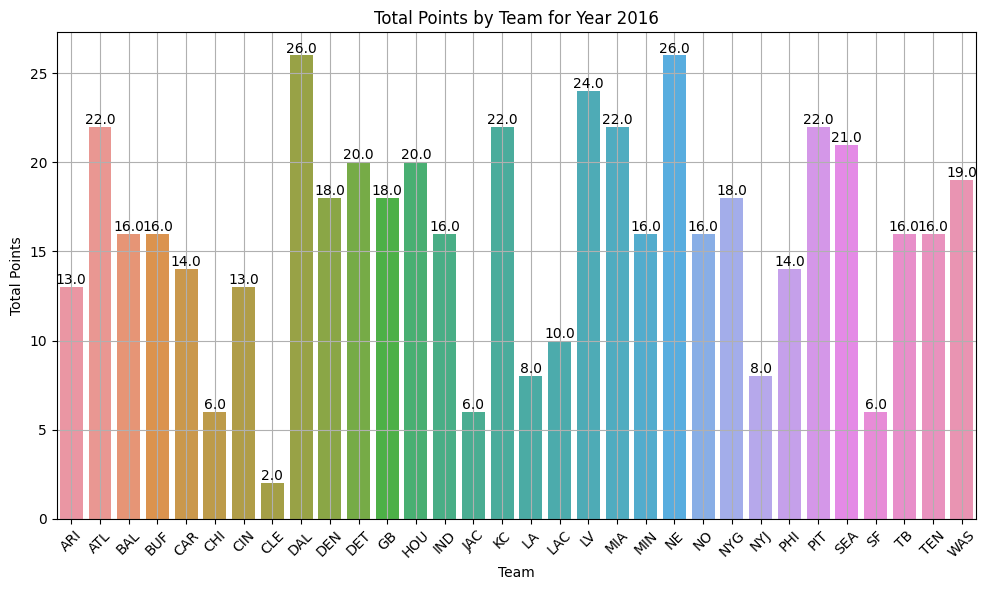

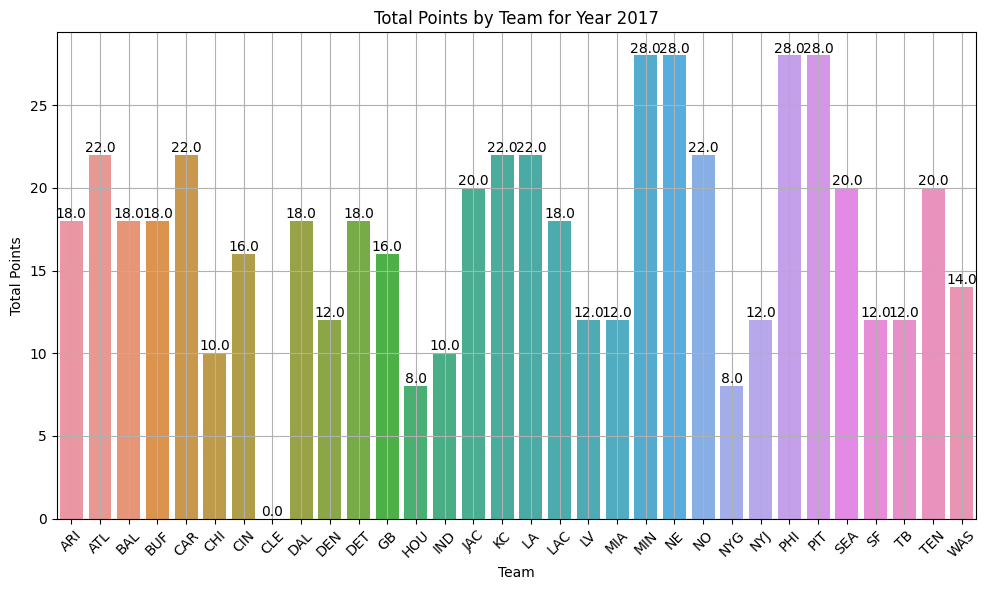

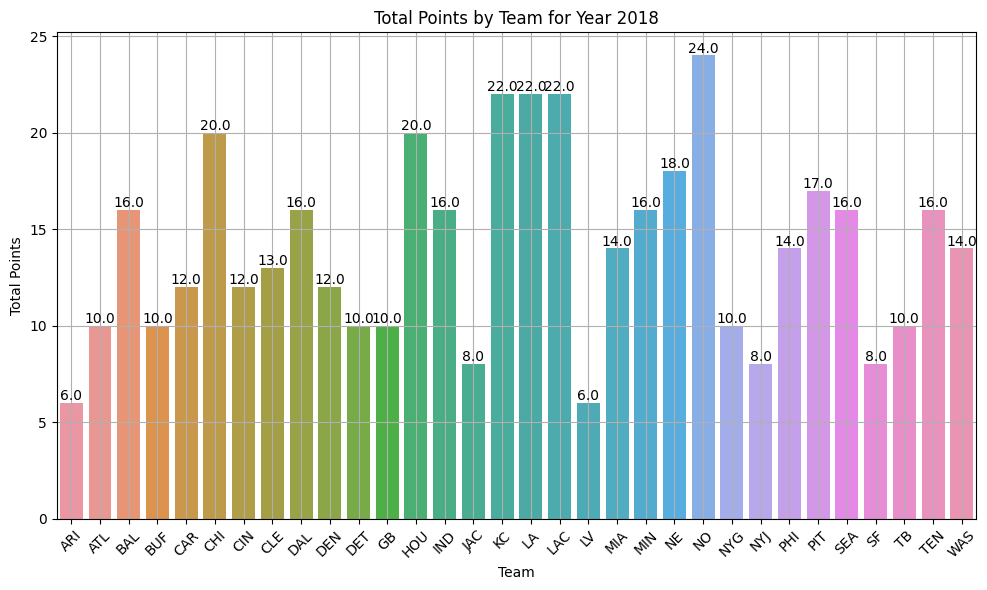

In [24]:
# Total points for Teams by each Year

all_points_data = []
for index, row in final_scores.iterrows():
    all_points_data.extend([(row['game_date'][:4], row['home_team'], row['home_team_points']),
                            (row['game_date'][:4], row['away_team'], row['away_team_points'])])

df = pd.DataFrame(all_points_data, columns=['Year', 'Team', 'Points'])
df = df.groupby(['Year', 'Team'])['Points'].sum().reset_index()

years = df['Year'].unique()
for year in years:
    plt.figure(figsize=(10, 6))
    df_year = df[df['Year'] == year]
    ax = sns.barplot(data=df_year, x='Team', y='Points')
    plt.title(f'Total Points by Team for Year {year}')
    plt.xlabel('Team')
    plt.ylabel('Total Points')
    plt.grid(True)
    plt.xticks(rotation=45)

    for p in ax.patches:
        ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()

In [25]:
# Creating interactive visualization of Games and it's Scores

import plotly.express as px

fig = px.scatter(final_scores, x='total_home_score', y='total_away_score', color='home_team', hover_name='game_id')
fig.update_layout(title='Game Scores Scatter Plot', xaxis_title='Home Score', yaxis_title='Away Score')
fig.show()


<div style="text-align: center;">
  <span style="font-size: 10em;">✅</span>
</div>

## Challenge 3. Checking Hypothesis

<font size='4' face='Arial'>
    
When do the team has more chances to win? When it playing at 'Home' or 'Away'? 
    
<font size='2' face='Arial'>

In [26]:
# Create point differentials

final_scores['point_differential'] = final_scores['total_home_score'] - final_scores['total_away_score']

In [27]:
# Hypothesis testing example

from scipy.stats import ttest_ind

home_wins = final_scores[final_scores['home_team_points'] > final_scores['away_team_points']]['point_differential']
away_wins = final_scores[final_scores['home_team_points'] < final_scores['away_team_points']]['point_differential']

t_stat, p_value = ttest_ind(home_wins, away_wins)
print(f"T-statistic: {t_stat}, p-value: {p_value}")

T-statistic: 61.474235462515686, p-value: 0.0


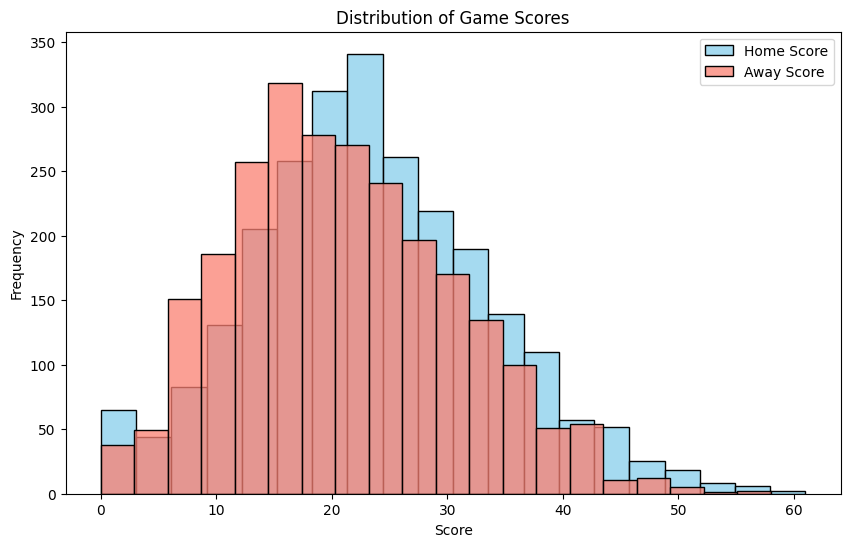

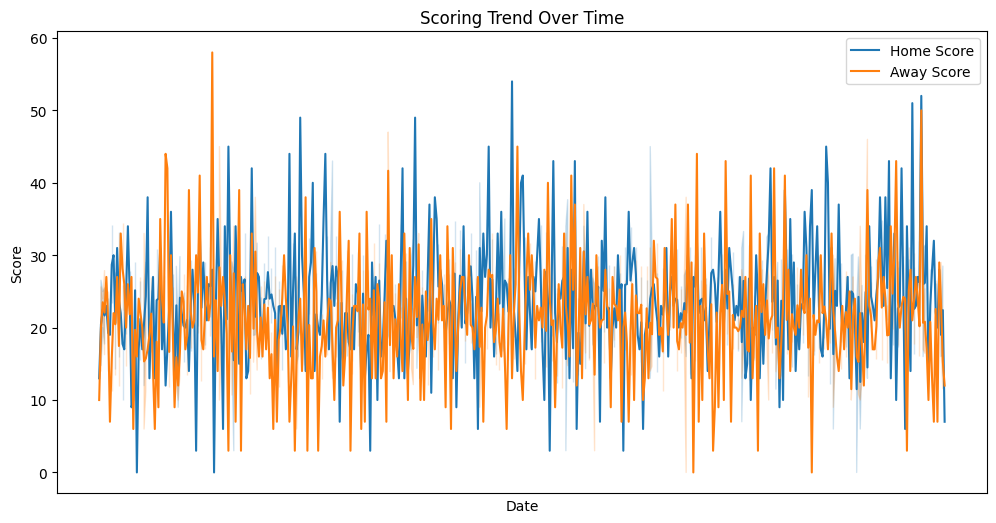

In [28]:
# Distribution of game scores

plt.figure(figsize=(10, 6))
sns.histplot(final_scores['total_home_score'], bins=20, color='skyblue', label='Home Score')
sns.histplot(final_scores['total_away_score'], bins=20, color='salmon', label='Away Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Game Scores')
plt.legend()
plt.show()

# Time series analysis

plt.figure(figsize=(12, 6))
sns.lineplot(data=final_scores, x='game_date', y='total_home_score', label='Home Score')
sns.lineplot(data=final_scores, x='game_date', y='total_away_score', label='Away Score')
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Scoring Trend Over Time')
plt.xticks([], [])

plt.legend()
plt.show()

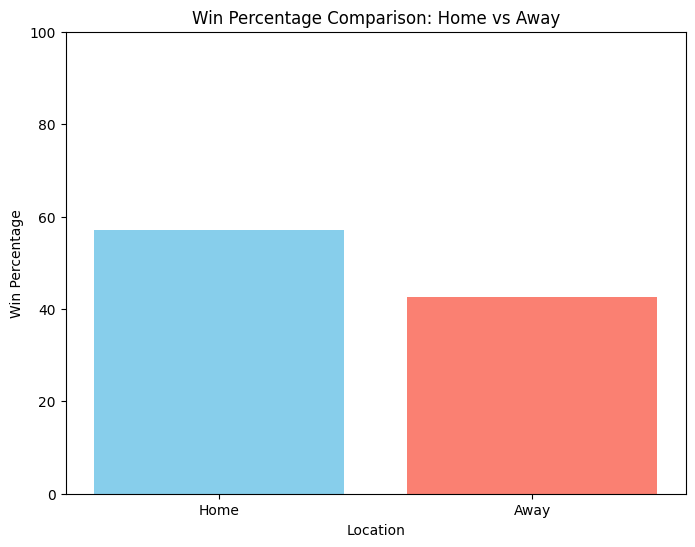

In [29]:

home_wins = final_scores[final_scores['home_team_points'] > final_scores['away_team_points']].shape[0]
away_wins = final_scores[final_scores['away_team_points'] > final_scores['home_team_points']].shape[0]

total_games = len(final_scores)

home_win_percentage = (home_wins / total_games) * 100
away_win_percentage = (away_wins / total_games) * 100

win_data = pd.DataFrame({
    'Location': ['Home', 'Away'],
    'Win Percentage': [home_win_percentage, away_win_percentage]
})

plt.figure(figsize=(8, 6))
plt.bar(win_data['Location'], win_data['Win Percentage'], color=['skyblue', 'salmon'])
plt.xlabel('Location')
plt.ylabel('Win Percentage')
plt.title('Win Percentage Comparison: Home vs Away')
plt.ylim(0, 100)
plt.show()

<div style="text-align: center;">
  <span style="font-size: 10em;">✅</span>
</div>

## Prediction model

In [30]:
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Train-test split
X = final_scores[['total_home_score', 'total_away_score']]
y = final_scores['home_team_points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Prdiction and Evaluation

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       218
           1       0.00      0.00      0.00         1
           2       0.99      0.99      0.99       287

    accuracy                           0.99       506
   macro avg       0.66      0.66      0.66       506
weighted avg       0.99      0.99      0.99       506



<div style="text-align: center;">
  <span style="font-size: 15em;">🙏</span>
</div>